# ML protein only

> In this module, we train the data use various ML and DL methods

In [ ]:
#| hide
import sys
sys.path.append("/notebooks/katlas")
from nbdev.showdoc import *
%matplotlib inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from fastbook import *
from katlas.core import Data
from katlas.feature import *
# from katlas.train import *
from katlas.plot import *

from sklearn.neighbors import *
from sklearn.linear_model import *
from sklearn.tree import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr,pearsonr

import xgboost as xgb
from joblib import dump
from xgboost import XGBRegressor

# import matplotlib.pyplot as plt
import math

/usr/local/lib/python3.9/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

## Setup

In [ ]:
def get_splits(df, # df contains info for split
               stratified=None, # colname to make stratified kfold; sampling from different groups
               group=None, # colname to make group kfold; test and train are from different groups
               nfold=5,
              seed = 123):
    # train_idx, test_idx = None, None
    
    splits = []
    if stratified is not None and group is None:
        kf = StratifiedKFold(nfold,shuffle=True, random_state = seed)
        for split in kf.split(df.index, df[stratified]):
            splits.append(split)
        print(kf)
        print(f'# kinase {stratified} in train set: {df.loc[split[0]][stratified].unique().shape[0]}')
        print(f'# kinase {stratified} in test set: {df.loc[split[1]][stratified].unique().shape[0]}')
        
    elif group is not None and stratified is None:
        kf = GroupKFold(nfold)
        for split in kf.split(df.index, groups=df[group]):
            splits.append(split)
            
        print(kf)
        print(f'# kinase {group} in train set: {df.loc[split[0]][group].unique().shape[0]}')
        print(f'# kinase {group} in test set: {df.loc[split[1]][group].unique().shape[0]}')
        
    elif stratified is not None and group is not None:
        kf = StratifiedGroupKFold(nfold,shuffle=True, random_state = seed)
        for split in kf.split(df.index, groups=df[group], y=df[stratified]):
            splits.append(split)
            
        print(kf)    
        print(f'# kinase {stratified} in train set: {df.loc[split[0]][stratified].unique().shape[0]}')
        print(f'# kinase {stratified} in test set: {df.loc[split[1]][stratified].unique().shape[0]}')
    else:
        raise ValueError("Either 'stratified' or 'group' argument must be provided.")
        
        
    print('---------------------------')
    print(f'# kinase in train set: {df.loc[split[0]].kinase.unique().shape[0]}')
    
    print('---------------------------')
    print(f'# kinase in test set: {df.loc[split[1]].kinase.unique().shape[0]}')
    print('---------------------------')
    print(f'test set: {df.loc[split[1]].kinase.unique()}')
    
    return splits

In [ ]:
def split_data(df, feat_col, target_col, split):
    
    X_train = df.loc[split[0]][feat_col]
    y_train = df.loc[split[0]][target_col]
    
    X_test = df.loc[split[1]][feat_col]
    y_test = df.loc[split[1]][target_col]
    
    return X_train, y_train, X_test, y_test

In [ ]:
def train_ml(df,
             feat_col,
             target_col,
             split,
             model,  
             save = None, # file (.joblib) to save
             params={},
            ):
    
    # split data
    X_train, y_train, X_test, y_test = split_data(df, feat_col, target_col, split)
    
    # Fit the model
    model.fit(X_train, y_train, **params) # better convert y_train to numpy array and flatten
    
    if save is not None:
        # Save the model to a file
        # joblib.dump(model, save)
        dump(model, save)
    
    # Predict
    y_pred = model.predict(X_test) # X_test is dataframe, y_pred is numpy array
    y_pred = pd.DataFrame(y_pred,index=y_test.index, columns = y_test.columns)
    
    
    return y_test, y_pred #two dataframes

In [ ]:
def predict_ml(df,
               feat_col,
               model_pth):
    
    test = df[feat_col]
    
    model = load(model_pth)
    
    pred = model.predict(test)
    
    pred_df = pd.DataFrame(pred)
    
    return pred_df

In [ ]:
def score_all(target, pred):
    
    # Calculate RMSE
    mse = mean_squared_error(target, pred)
    rmse = math.sqrt(mse)
    print(f'rmse is {rmse:.4f}')

    # Calculate the Spearman correlation coefficient
    spearman_corr, _ = spearmanr(target.values.ravel(), pred.values.ravel())
    print(f"Spearman correlation coefficient: {spearman_corr:.4f}")

    # Calculate the Pearson correlation coefficient
    pearson_corr, _ = pearsonr(target.values.ravel(), pred.values.ravel())
    print(f"Pearson correlation coefficient: {pearson_corr:.4f} ")

In [ ]:
def score_each(target,pred, absolute=False):
    pred.columns = target.columns
    sp = target.corrwith(pred,axis=1,method='spearman')
    
    pear = target.corrwith(pred,axis=1,method='pearson')
    
    df = pd.DataFrame(np.stack([sp,pear]).T,columns = ['spearman','pearson'])
    if absolute ==True:
        df = df.apply(abs)
        
    # print(f'average spearman of kinase is {df.spearman.mean()}')
    # print(f'average pearson of kinase is {df.pearson.mean()}')
    return df

## Kinase EDA

Use uniprot human full sequence

In [ ]:
kinase = Data.get_kinase_info_full()
kinase = kinase.drop_duplicates('human_uniprot_sequence')

To use cutted kinase sequence

In [ ]:
kinase = Data.get_kinase_info_full()
kinase = kinase.query('pseudo == 0') # remove all pseudo kinase, as their uniprot sequence is duplicate of original
kinase = kinase.drop_duplicates('sequence') #remove sgk424 in TEX14 kinase, leave only Sgk307
# the above is equivalent to kinase.drop_duplicates('sequence').query('pseudo == 0')
# we need to remove pseudo ==0 after drop duplicates of sequence, 
# because one pseudo full kinase is actually a duplicate of a cutted kinase from paper, they are different in length.

To use kinase domain

In [ ]:
kinase = Data.get_kinase_info_full()
kinase = kinase[~kinase.kinasecom_domain.isnull()] #drop kinase domain that is nan, no duplicates after removing nan
inconsistant = kinase[~kinase.apply(lambda row: str(row['kinasecom_domain']) in str(row['human_uniprot_sequence']), axis=1)]

In [ ]:
inconsistant.shape

(28, 22)

In [ ]:
for i, r in inconsistant.iterrows():
    local_align(r.human_uniprot_sequence,r.kinasecom_domain)

Score:  512.0
Start index:  21
End index:  277
MEGDGGTPWALALLRTFDAGEFTGWEKVGSGGFGQVYKVRHVHWKTWLAIKCSPSLHVDDRERMELLEEA
                     |||||||||||||||||||||||||||||||||||||||||||||||||
---------------------FTGWEKVGSGGFGQVYKVRHVHWKTWLAIKCSPSLHVDDRERMELLEEA

KKMEMAKFRYILPVYGICREPVGLVMEYMETGSLEKLLASEPLPWDLRFRIIHETAVGMNFLHCMAPPLL
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
KKMEMAKFRYILPVYGICREPVGLVMEYMETGSLEKLLASEPLPWDLRFRIIHETAVGMNFLHCMAPPLL

HLDLKPANILLDAHYHVKISDFGLAKCNGLSHSHDLSMDGLFGTIAYLPPERIREKSRLFDTKHDVYSFA
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
HLDLKPANILLDAHYHVKISDFGLAKCNGLSHSHDLSMDGLFGTIAYLPPERIREKSRLFDTKHDVYSFA

IVIWGVLTQKKPFADEKNILHIMVKVVKGHRPELPPVCRARPRACSHLIRLMQRCWQGDPRVRPTFQGNG
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||   
IVIWGVLTQKKPFADEKNILHIMVKVVKGHRPELPPVCRARPRACSHLIRLMQRCWQGDPRVRPTFQEIT

LNGELIRQVLAALLPVTGRWRSPGEGFRLESEVIIRVTCPLSSPQEITSETEDLCEKPDDEVKETAHDLD
   |                      

It seems there are slight differences between the domain from kinase.com vs the uniprot sequence.

We will use domain sequence from kinase.come

## Data

In [ ]:
df = pd.read_parquet('train/scaled_t5.parquet')

In [ ]:
kinase = Data.get_kinase_info_full()

info = kinase.query('in_paper == 1')

info = df[['kinase']].merge(info,'left')

In [ ]:
feat_col = df.columns[199:]
target_col = df.columns[1:199]

In [ ]:
splits = get_splits(info, stratified = 'category', seed=456)

StratifiedKFold(n_splits=5, random_state=456, shuffle=True)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
---------------------------
# kinase in test set: 60
---------------------------
test set: ['ACVR2A' 'AKT2' 'ALK4' 'ANKRD3' 'ATR' 'AURC' 'CAMK1B' 'CAMK1D' 'CDK1' 'CDK16' 'CDK18' 'CDK8' 'CK1G2' 'CK1G3' 'DAPK1' 'DCAMKL1' 'ERK5' 'GRK5' 'HIPK2' 'HPK1' 'IRAK1' 'JNK2' 'MARK3' 'MASTL' 'MEKK6'
 'MINK' 'MLK1' 'MNK2' 'MOK' 'MPSK1' 'MST1' 'MST4' 'NDR2' 'NEK11' 'NEK6' 'OSR1' 'P38G' 'P70S6K' 'PASK' 'PDHK4' 'PDK1' 'PERK' 'PHKG2' 'PIM2' 'PKACG' 'PKCG' 'PKCH' 'PLK1' 'PRKD2' 'PRKD3' 'RAF1' 'RIPK3'
 'SRPK1' 'SSTK' 'TBK1' 'TNIK' 'ULK1' 'VRK1' 'VRK2' 'WNK4']


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
splits = get_splits(info, stratified = 'category', seed=393)

StratifiedKFold(n_splits=5, random_state=393, shuffle=True)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
---------------------------
# kinase in test set: 60
---------------------------
test set: ['AKT2' 'ALK2' 'ATM' 'AURA' 'BCKDK' 'BMPR1A' 'CAMKK1' 'CAMLCK' 'CDC7' 'CDK1' 'CDK12' 'CDK19' 'CDK4' 'CHAK2' 'CHK1' 'CK1G2' 'CK1G3' 'GRK5' 'HIPK3' 'HIPK4' 'HPK1' 'ICK' 'IKKB' 'JNK3' 'KIS' 'MAP3K15'
 'MAPKAPK2' 'MEKK2' 'MLK1' 'MST3' 'MYLK4' 'MYO3A' 'NDR1' 'NEK4' 'NUAK2' 'P70S6K' 'PAK2' 'PAK3' 'PDHK1' 'PDK1' 'PHKG1' 'PIM1' 'PKCA' 'PKG2' 'PKN1' 'PLK2' 'PRKD1' 'RIPK1' 'RIPK2' 'RSK2' 'SIK' 'SRPK1'
 'STLK3' 'TAK1' 'TAO3' 'TGFBR2' 'TLK1' 'ULK1' 'WNK3' 'YSK4']


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
model = LinearRegression()

In [ ]:
def get_OOF(model,splits):
    OOF = []
    for split in splits:
        target, pred = train_ml(df, feat_col, target_col, split, model)
        score_all(target,pred)
        OOF.append(pred)

    OOF = pd.concat(OOF).sort_index()
    # target = df[target_col]
    # cor = score_each(target,OOF)
    return OOF

In [ ]:
def get_results(model, seeds):
    OOFs,cors,sps,ps = {},{},{},{}
    target = df[target_col]

    for seed in seeds:
        splits = get_splits(info, stratified = 'category', seed=seed)
        OOF = get_OOF(model, splits)
        cor = score_each(target, OOF)
        print(f'spearman is: {cor.spearman.mean()}')
        print(f'pearson is : {cor.pearson.mean()}')
        OOFs[seed],cors[seed],sps[seed],ps[seed] = OOF,cor,cor.spearman.mean(),cor.pearson.mean()
    sp_df = pd.DataFrame({'spearman':sps, 'pearson':ps})
    print(f'spearman across seeds is {sp_df.spearman.mean()}')
    print(f'pearson across seeds is {sp_df.pearson.mean()}')
    return OOFs, cors, sp_df


In [ ]:
_,_,_ = get_results(LinearRegression(),[2021,2022,2023])

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
---------------------------
# kinase in test set: 60
---------------------------
test set: ['ACVR2A' 'ACVR2B' 'ALPHAK3' 'CAMK4' 'CAMKK2' 'CDK17' 'CDK5' 'CDK8' 'CDK9' 'CHK1' 'CK1A' 'CK1G3' 'DCAMKL1' 'DNAPK' 'EEF2K' 'GRK1' 'HIPK4' 'HRI' 'ICK' 'IKKB' 'IRAK4' 'KHS2' 'LATS2' 'MAPKAPK2' 'MASTL'
 'MEK1' 'MEKK2' 'MEKK3' 'MEKK6' 'MINK' 'MOK' 'MRCKA' 'MYLK4' 'MYO3A' 'NEK4' 'NEK8' 'NIK' 'NIM1' 'NUAK2' 'OSR1' 'P38A' 'P38G' 'PAK3' 'PDHK1' 'PIM2' 'PIM3' 'PKCE' 'PKCG' 'PKCT' 'PKG2' 'PKN2' 'PLK4'
 'PRKX' 'QIK' 'RSK3' 'SBK' 'SLK' 'SRPK1' 'TTK' 'WNK4']
rmse is 1.0508
Spearman correlation coefficient: 0.5071
Pearson correlation coefficient: 0.5830 
rmse is 0.9939
Spearman correlation coefficient: 0.5350
Pearson correlation coefficient: 0.6365 
rmse is 0.8914
Spearman correlation coefficient: 0.5342
Pearson correlation coef

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


rmse is 1.0226
Spearman correlation coefficient: 0.4670
Pearson correlation coefficient: 0.5767 
rmse is 1.0620
Spearman correlation coefficient: 0.5089
Pearson correlation coefficient: 0.6141 
rmse is 1.0436
Spearman correlation coefficient: 0.4862
Pearson correlation coefficient: 0.5984 
rmse is 0.9010
Spearman correlation coefficient: 0.5036
Pearson correlation coefficient: 0.6764 
rmse is 1.0425
Spearman correlation coefficient: 0.5311
Pearson correlation coefficient: 0.6185 
spearman is: 0.5111865631673018
pearson is : 0.5916705333354423
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
---------------------------
# kinase in test set: 60
---------------------------
test set: ['ACVR2A' 'ALK2' 'ALPHAK3' 'ANKRD3' 'ATM' 'BMPR2' 'CAMKK2' 'CDC7' 'CDK16' 'CDK17' 'CDK5' 'CHAK2' 'CHK1' 'CK1A' 'CK1G1' 'CLK1' 'CRIK' 'DAPK3' 'DYRK1B' 'ERK1' 'GCK' 'GCN2' 'GRK3

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


rmse is 0.9983
Spearman correlation coefficient: 0.5102
Pearson correlation coefficient: 0.6271 
rmse is 1.1412
Spearman correlation coefficient: 0.4618
Pearson correlation coefficient: 0.5164 
rmse is 1.0000
Spearman correlation coefficient: 0.4662
Pearson correlation coefficient: 0.6263 
rmse is 1.2713
Spearman correlation coefficient: 0.4875
Pearson correlation coefficient: 0.5402 
spearman is: 0.504502208420699
pearson is : 0.5879764663469635
spearman across seeds is 0.5099045963789274
pearson across seeds is 0.5933376471587787


In [ ]:
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
_,_,_ = get_results(KNeighborsRegressor(n_neighbors=3),[2021,2022,2023])

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
---------------------------
# kinase in test set: 60
---------------------------
test set: ['ACVR2A' 'ACVR2B' 'ALPHAK3' 'CAMK4' 'CAMKK2' 'CDK17' 'CDK5' 'CDK8' 'CDK9' 'CHK1' 'CK1A' 'CK1G3' 'DCAMKL1' 'DNAPK' 'EEF2K' 'GRK1' 'HIPK4' 'HRI' 'ICK' 'IKKB' 'IRAK4' 'KHS2' 'LATS2' 'MAPKAPK2' 'MASTL'
 'MEK1' 'MEKK2' 'MEKK3' 'MEKK6' 'MINK' 'MOK' 'MRCKA' 'MYLK4' 'MYO3A' 'NEK4' 'NEK8' 'NIK' 'NIM1' 'NUAK2' 'OSR1' 'P38A' 'P38G' 'PAK3' 'PDHK1' 'PIM2' 'PIM3' 'PKCE' 'PKCG' 'PKCT' 'PKG2' 'PKN2' 'PLK4'
 'PRKX' 'QIK' 'RSK3' 'SBK' 'SLK' 'SRPK1' 'TTK' 'WNK4']
spearman is: 0.6434716271956723
pearson is : 0.662867043397454
StratifiedKFold(n_splits=5, random_state=2022, shuffle=True)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
--------------------------

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


spearman is: 0.648521694018414
pearson is : 0.6719473933193111
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
---------------------------
# kinase in test set: 60
---------------------------
test set: ['ACVR2A' 'ALK2' 'ALPHAK3' 'ANKRD3' 'ATM' 'BMPR2' 'CAMKK2' 'CDC7' 'CDK16' 'CDK17' 'CDK5' 'CHAK2' 'CHK1' 'CK1A' 'CK1G1' 'CLK1' 'CRIK' 'DAPK3' 'DYRK1B' 'ERK1' 'GCK' 'GCN2' 'GRK3' 'HIPK1' 'HPK1' 'IRE2'
 'JNK2' 'LATS1' 'MAPKAPK2' 'MAPKAPK5' 'MARK4' 'MEKK1' 'MEKK2' 'MEKK6' 'MINK' 'MLK4' 'MNK1' 'MNK2' 'MRCKA' 'MSK2' 'NEK3' 'NIK' 'NLK' 'P38A' 'PHKG2' 'PIM1' 'PKACA' 'PKACG' 'PKCA' 'PKCD' 'RAF1' 'RIPK3'
 'SMMLCK' 'TAO1' 'TBK1' 'TSSK2' 'TTK' 'ULK2' 'VRK2' 'WNK1']
spearman is: 0.6480862734413213
pearson is : 0.6677533790357244
spearman across seeds is 0.6466931982184692
pearson across seeds is 0.6675226052508298


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
_,_,_ = get_results(MultiOutputRegressor(SVR(C=10)),[2021,2022,2023])

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
---------------------------
# kinase in test set: 60
---------------------------
test set: ['ACVR2A' 'ACVR2B' 'ALPHAK3' 'CAMK4' 'CAMKK2' 'CDK17' 'CDK5' 'CDK8' 'CDK9' 'CHK1' 'CK1A' 'CK1G3' 'DCAMKL1' 'DNAPK' 'EEF2K' 'GRK1' 'HIPK4' 'HRI' 'ICK' 'IKKB' 'IRAK4' 'KHS2' 'LATS2' 'MAPKAPK2' 'MASTL'
 'MEK1' 'MEKK2' 'MEKK3' 'MEKK6' 'MINK' 'MOK' 'MRCKA' 'MYLK4' 'MYO3A' 'NEK4' 'NEK8' 'NIK' 'NIM1' 'NUAK2' 'OSR1' 'P38A' 'P38G' 'PAK3' 'PDHK1' 'PIM2' 'PIM3' 'PKCE' 'PKCG' 'PKCT' 'PKG2' 'PKN2' 'PLK4'
 'PRKX' 'QIK' 'RSK3' 'SBK' 'SLK' 'SRPK1' 'TTK' 'WNK4']
spearman is: 0.6679474520677614
pearson is : 0.6902609964750317
StratifiedKFold(n_splits=5, random_state=2022, shuffle=True)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
-------------------------

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


spearman is: 0.6733561910050115
pearson is : 0.6931562959977551
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
---------------------------
# kinase in test set: 60
---------------------------
test set: ['ACVR2A' 'ALK2' 'ALPHAK3' 'ANKRD3' 'ATM' 'BMPR2' 'CAMKK2' 'CDC7' 'CDK16' 'CDK17' 'CDK5' 'CHAK2' 'CHK1' 'CK1A' 'CK1G1' 'CLK1' 'CRIK' 'DAPK3' 'DYRK1B' 'ERK1' 'GCK' 'GCN2' 'GRK3' 'HIPK1' 'HPK1' 'IRE2'
 'JNK2' 'LATS1' 'MAPKAPK2' 'MAPKAPK5' 'MARK4' 'MEKK1' 'MEKK2' 'MEKK6' 'MINK' 'MLK4' 'MNK1' 'MNK2' 'MRCKA' 'MSK2' 'NEK3' 'NIK' 'NLK' 'P38A' 'PHKG2' 'PIM1' 'PKACA' 'PKACG' 'PKCA' 'PKCD' 'RAF1' 'RIPK3'
 'SMMLCK' 'TAO1' 'TBK1' 'TSSK2' 'TTK' 'ULK2' 'VRK2' 'WNK1']


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


spearman is: 0.6690295602583496
pearson is : 0.6901482173911749
spearman across seeds is 0.6701110677770409
pearson across seeds is 0.6911885032879872


In [ ]:
params = {'max_depth': 7, 
          'learning_rate': 0.001, 
          'subsample': 0.8, 
          'colsample_bytree': 1, 
          'eval_metric': 'rmse', 
          'objective': 'reg:squarederror', 
          'tree_method': 'gpu_hist', 
          'predictor': 'gpu_predictor', 
          'random_state': 123}

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 21.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 41.3 MB/s eta 0:00:0000:0100:01


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
m = XGBRegressor()

In [ ]:
m = MultiOutputRegressor(CatBoostRegressor())

In [ ]:
_,_,_ = get_results(RandomForestRegressor(),[2021,2022,2023])

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
---------------------------
# kinase in test set: 60
---------------------------
test set: ['ACVR2A' 'ACVR2B' 'ALPHAK3' 'CAMK4' 'CAMKK2' 'CDK17' 'CDK5' 'CDK8' 'CDK9' 'CHK1' 'CK1A' 'CK1G3' 'DCAMKL1' 'DNAPK' 'EEF2K' 'GRK1' 'HIPK4' 'HRI' 'ICK' 'IKKB' 'IRAK4' 'KHS2' 'LATS2' 'MAPKAPK2' 'MASTL'
 'MEK1' 'MEKK2' 'MEKK3' 'MEKK6' 'MINK' 'MOK' 'MRCKA' 'MYLK4' 'MYO3A' 'NEK4' 'NEK8' 'NIK' 'NIM1' 'NUAK2' 'OSR1' 'P38A' 'P38G' 'PAK3' 'PDHK1' 'PIM2' 'PIM3' 'PKCE' 'PKCG' 'PKCT' 'PKG2' 'PKN2' 'PLK4'
 'PRKX' 'QIK' 'RSK3' 'SBK' 'SLK' 'SRPK1' 'TTK' 'WNK4']
rmse is 0.6781
Spearman correlation coefficient: 0.6281
Pearson correlation coefficient: 0.7189 
rmse is 0.8936
Spearman correlation coefficient: 0.6368
Pearson correlation coefficient: 0.6381 
rmse is 0.8268
Spearman correlation coefficient: 0.6512
Pearson correlation coef

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


rmse is 0.7875
Spearman correlation coefficient: 0.5978
Pearson correlation coefficient: 0.6466 
rmse is 0.8090
Spearman correlation coefficient: 0.6321
Pearson correlation coefficient: 0.6427 
rmse is 0.8442
Spearman correlation coefficient: 0.6399
Pearson correlation coefficient: 0.6929 
rmse is 0.7782
Spearman correlation coefficient: 0.6413
Pearson correlation coefficient: 0.7065 
rmse is 0.7584
Spearman correlation coefficient: 0.6479
Pearson correlation coefficient: 0.7413 
spearman is: 0.6282294677792707
pearson is : 0.6410769560092084
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
---------------------------
# kinase in test set: 60
---------------------------
test set: ['ACVR2A' 'ALK2' 'ALPHAK3' 'ANKRD3' 'ATM' 'BMPR2' 'CAMKK2' 'CDC7' 'CDK16' 'CDK17' 'CDK5' 'CHAK2' 'CHK1' 'CK1A' 'CK1G1' 'CLK1' 'CRIK' 'DAPK3' 'DYRK1B' 'ERK1' 'GCK' 'GCN2' 'GRK3

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


rmse is 0.6708
Spearman correlation coefficient: 0.6715
Pearson correlation coefficient: 0.7522 
rmse is 0.8836
Spearman correlation coefficient: 0.6266
Pearson correlation coefficient: 0.6393 
rmse is 0.9360
Spearman correlation coefficient: 0.6108
Pearson correlation coefficient: 0.5535 
rmse is 0.8028
Spearman correlation coefficient: 0.6131
Pearson correlation coefficient: 0.7145 
rmse is 0.6332
Spearman correlation coefficient: 0.6391
Pearson correlation coefficient: 0.7842 
spearman is: 0.6282585595482403
pearson is : 0.6428466692624166
spearman across seeds is 0.6292634474955529
pearson across seeds is 0.6438216261318512


In [ ]:
models = {
    
    # 'LinearRegression': LinearRegression(),
    # 'Ridge': Ridge(alpha=1.0),
    # 'Lasso': Lasso(0.1),
    # 'ElasticNet': ElasticNet(0.1),
    'SVR1': MultiOutputRegressor(SVR(C=1)),
    'SVR10': MultiOutputRegressor(SVR(C=10)),
    'SVR10_best':MultiOutputRegressor(SVR(C=10,gamma=1)),
    'SVR20':MultiOutputRegressor(SVR(C=20)),
    # 'DecisionTreeRegressor': DecisionTreeRegressor(),
    # 'KNN2': KNeighborsRegressor(n_neighbors=2),
    # 'KNN1': KNeighborsRegressor(n_neighbors=1),
    # 'KNN3': KNeighborsRegressor(n_neighbors=3),
    # 'XGBRegressor': XGBRegressor(max_depth=7),
    # 'RandomForestRegressor': RandomForestRegressor()
                                      }

In [ ]:
# param_grid = {
#     'estimator__C': [0.1, 1, 10, 100, 1000],
#     'estimator__epsilon': [0.01, 0.1, 1, 10],
#     'estimator__gamma': ['scale', 'auto', 0.01, 0.1, 1],
#     'estimator__kernel': ['rbf', 'linear', 'poly']
# }

# from sklearn.model_selection import GridSearchCV

# grid_search = GridSearchCV(MultiOutputRegressor(SVR()), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)

# train = df.loc[splits[0][0]]
# test = df.loc[splits[0][1]]

# X_tr = train[feat_col]
# y_tr = train[target_col]

# grid_search.fit(X_tr, y_tr)

# # Best Parameters: {'estimator__C': 10, 'estimator__epsilon': 0.1, 'estimator__gamma': 1, 'estimator__kernel': 'rbf'}
# # Best Score (Negative MSE): -0.9346966383049505

# print("Best Parameters:", grid_search.best_params_)
# print("Best Score (Negative MSE):", grid_search.best_score_)

In [ ]:
for name, model in models.items():
    print(f'--------------------{name}-------------------------')
    get_OOF(model)

--------------------SVR1-------------------------
MultiOutputRegressor(estimator=SVR(C=1))
rmse is 0.9365
Spearman correlation coefficient: 0.6508
Pearson correlation coefficient: 0.5534 
MultiOutputRegressor(estimator=SVR(C=1))
rmse is 0.9083
Spearman correlation coefficient: 0.6853
Pearson correlation coefficient: 0.4974 
MultiOutputRegressor(estimator=SVR(C=1))
rmse is 0.9839
Spearman correlation coefficient: 0.6746
Pearson correlation coefficient: 0.4619 
MultiOutputRegressor(estimator=SVR(C=1))
rmse is 0.9431
Spearman correlation coefficient: 0.6710
Pearson correlation coefficient: 0.4976 
MultiOutputRegressor(estimator=SVR(C=1))
rmse is 0.9985
Spearman correlation coefficient: 0.6690
Pearson correlation coefficient: 0.5169 
average spearman of kinase is 0.6644301540905068
average pearson of kinase is 0.5864916089462348
--------------------SVR10-------------------------
MultiOutputRegressor(estimator=SVR(C=10))
rmse is 0.8066
Spearman correlation coefficient: 0.6358
Pearson correl

In [ ]:
# pred = predict_ml(df,feat_col, 'model.joblib')

In [ ]:
kinase = Data.get_kinase_info_full()

In [ ]:
kinase[~kinase.apply(lambda row: str(row['kinasecom_domain']) in str(row['human_uniprot_sequence']), axis=1)]

In [ ]:
kinase = kinase.query('pseudo == 0') # remove all pseudo kinase, as their uniprot sequence is duplicate of original

In [ ]:
kinase = kinase.drop_duplicates('sequence') #remove sgk424 in TEX14 kinase, leave only Sgk307

In [ ]:
kinase.drop_duplicates('sequence').query('pseudo == 1')

,kinase,ID_coral,uniprot,ID_HGNC,group,family,subfamily_coral,subfamily,in_paper,pseudo,species_paper,uniprot_paper,range,human_uniprot_sequence,full_sequence_paper,sequence,category,category_big,cluster,length,kinasecom_domain,hdbscan
175,EIF2AK4,GCN2_b,Q9P2K8,EIF2AK4,STE,STE-Unique,None,STE-Unique,0,1,human,Q9P2K8,Full length,MAGGRGAPGRGRDEPPESYPQRQDHELQALEAIYGADFQDLRPDACGPVKEPPEINLVLYPQGLTGEEVYVKVDLRVKCPPTYPDVVPEIELKNAKGLSNESVNLLKSRLEELAKKHCGEVMIFELAYHVQSFLSEHNKPPPKSFHEEMLERRAQEEQQRLLEAKRKEEQEQREILHEIQRRKEEIKEEKKRKEMAKQERLEIASLSNQDHTSKKDPGGHRTAAILHGGSPDFVGNGKHRANSSGRSRRERQYSVCNSEDSPGSCEILYFNMGSPDQLMVHKGKCIGSDEQLGKLVYNALETATGGFVLLYEWVLQWQKKMGPFLTSQEKEKIDKCKKQIQGTETEFNSLVKLSHPNVVRYLAMNLKEQDDSIVVDILVEHISGVSLAAHLSHSGPIPVHQLRRYTAQLLSGLDYLHSNSVVHKVLSASNVLVDAEGTVKITDYSISKRLADICKEDVFEQTRVRFSDNALPYKTGKKGDVWRLGLLLLSLSQGQECGEYPVTIPSDLPADFQDFLKKCVCLDDKERWSPQQLLKHSFINPQPKMPLVEQSPEDSEGQDYVETVIPSNRLPSAAFFSETQRQFSRYFIEFEELQLL...,MAGGRGAPGRGRDEPPESYPQRQDHELQALEAIYGADFQDLRPDACGPVKEPPEINLVLYPQGLTGEEVYVKVDLRVKCPPTYPDVVPEIELKNAKGLSNESVNLLKSRLEELAKKHCGEVMIFELAYHVQSFLSEHNKPPPKSFHEEMLERRAQEEQQRLLEAKRKEEQEQREILHEIQRRKEEIKEEKKRKEMAKQERLEIASLSNQDHTSKKDPGGHRTAAILHGGSPDFVGNGKHRANSSGRSRRERQYSVCNSEDSPGSCEILYFNMGSPDQLMVHKGKCIGSDEQLGKLVYNALETATGGFVLLYEWVLQWQKKMGPFLTSQEKEKIDKCKKQIQGTETEFNSLVKLSHPNVVRYLAMNLKEQDDSIVVDILVEHISGVSLAAHLSHSGPIPVHQLRRYTAQLLSGLDYLHSNSVVHKVLSASNVLVDAEGTVKITDYSISKRLADICKEDVFEQTRVRFSDNALPYKTGKKGDVWRLGLLLLSLSQGQECGEYPVTIPSDLPADFQDFLKKCVCLDDKERWSPQQLLKHSFINPQPKMPLVEQSPEDSEGQDYVETVIPSNRLPSAAFFSETQRQFSRYFIEFEELQLL...,MAGGRGAPGRGRDEPPESYPQRQDHELQALEAIYGADFQDLRPDACGPVKEPPEINLVLYPQGLTGEEVYVKVDLRVKCPPTYPDVVPEIELKNAKGLSNESVNLLKSRLEELAKKHCGEVMIFELAYHVQSFLSEHNKPPPKSFHEEMLERRAQEEQQRLLEAKRKEEQEQREILHEIQRRKEEIKEEKKRKEMAKQERLEIASLSNQDHTSKKDPGGHRTAAILHGGSPDFVGNGKHRANSSGRSRRERQYSVCNSEDSPGSCEILYFNMGSPDQLMVHKGKCIGSDEQLGKLVYNALETATGGFVLLYEWVLQWQKKMGPFLTSQEKEKIDKCKKQIQGTETEFNSLVKLSHPNVVRYLAMNLKEQDDSIVVDILVEHISGVSLAAHLSHSGPIPVHQLRRYTAQLLSGLDYLHSNSVVHKVLSASNVLVDAEGTVKITDYSISKRLADICKEDVFEQTRVRFSDNALPYKTGKKGDVWRLGLLLLSLSQGQECGEYPVTIPSDLPADFQDFLKKCVCLDDKERWSPQQLLKHSFINPQPKMPLVEQSPEDSEGQDYVETVIPSNRLPSAAFFSETQRQFSRYFIEFEELQLL...,None,None,NaN,1649,VHKGKCIGSDEQLGKLVYNALETATGGFVLLYEWVLQWQKKMGPFLTSQEKEKIDKCKKQIQGTETEFNSLVKLSHPNVVRYLAMNLKEQDDSIVVDILVEHISGVSLAAHLSHSGPIPVHQLRRYTAQLLSGLDYLHSNSVVHKVLSASNVLVDAEGTVKITDYSISKRLADICKEDVFEQTRVRFSDNALPYKTGKKGDVWRLGLLLLSLSQGQECGEYPVTIPSDLPADFQDFLKKCVCLDDKERWSPQQLLKHSFI,NaN


In [ ]:
kinase[kinase.duplicated('kinasecom_domain',keep=False)].to_csv('kinase_domain_same.csv', index=False)

In [ ]:
s = kinase[kinase.duplicated('sequence',keep=False)].set_index('kinase')

In [ ]:
kinase.shape

(509, 22)

In [ ]:
s.loc['TEX14']

,ID_coral,uniprot,ID_HGNC,group,family,subfamily_coral,subfamily,in_paper,pseudo,species_paper,uniprot_paper,range,human_uniprot_sequence,full_sequence_paper,sequence,category,category_big,cluster,length,kinasecom_domain,hdbscan
kinase,,,,,,,,,,,,,,,,,,,,,
TEX14,SgK307,Q8IWB6,TEX14,Other,NKF5,None,NKF5,0,0,human,Q8IWB6,Full length,MSRAVRLPVPCPVQLGTLRNDSLEAQLHEYVKQGNYVKVKKILKKGIYVDAVNSLGQTALFVAALLGLRKFVDVLVDYGSDPNHRCFDGSTPVHAAAFSGNQWILSKLLDAGGDLRLHDERGQNPKTWALTAGKERSTQIVEFMQRCASHMQAIIQGFSYDLLKKIDSPQRLVYSPSWCGGLVQGNPNGSPNRLLKAGVISAQNIYSFGFGKAMPWFQFYLTGATQMAYLGSLPVIGEKEVIQADDEPTFSFFSGPYMVMTNLVWNGSRVTVKELNLPTHPHCSRLRLADLLIAEQEHSSKLRHPYLLQLMAVCLSQDLEKTRLVYERITIGTLFSVLHERRSQFPVLHMEVIVHLLLQISDALRYLHFQGFIHRSLSSYAVHIISPGEARLTNLEYMLESEDRGVQRDLTRVPLPTQLYNWAAPEVILQKAATVKSDIYSFSMIMQEILTDDIPWKGLDGSVVKKAVVSGNYLEADVRLPKPYYDIVKSGIHVKQKDRTMNLQDIRYILKNDLKDFTGAQRTQPTESPRVQRYGLHPDVNVYLGLTSEHPRETPDMEIIELKEMGSQPHSPRVHSLFTEGTLDPQAPDPCLMARE...,MSRAVRLPVPCPVQLGTLRNDSLEAQLHEYVKQGNYVKVKKILKKGIYVDAVNSLGQTALFVAALLGLRKFVDVLVDYGSDPNHRCFDGSTPVHAAAFSGNQWILSKLLDAGGDLRLHDERGQNPKTWALTAGKERSTQIVEFMQRCASHMQAIIQGFSYDLLKKIDSPQRLVYSPSWCGGLVQGNPNGSPNRLLKAGVISAQNIYSFGFGKAMPWFQFYLTGATQMAYLGSLPVIGEKEVIQADDEPTFSFFSGPYMVMTNLVWNGSRVTVKELNLPTHPHCSRLRLADLLIAEQEHSSKLRHPYLLQLMAVCLSQDLEKTRLVYERITIGTLFSVLHERRSQFPVLHMEVIVHLLLQISDALRYLHFQGFIHRSLSSYAVHIISPGEARLTNLEYMLESEDRGVQRDLTRVPLPTQLYNWAAPEVILQKAATVKSDIYSFSMIMQEILTDDIPWKGLDGSVVKKAVVSGNYLEADVRLPKPYYDIVKSGIHVKQKDRTMNLQDIRYILKNDLKDFTGAQRTQPTESPRVQRYGLHPDVNVYLGLTSEHPRETPDMEIIELKEMGSQPHSPRVHSLFTEGTLDPQAPDPCLMARE...,MSRAVRLPVPCPVQLGTLRNDSLEAQLHEYVKQGNYVKVKKILKKGIYVDAVNSLGQTALFVAALLGLRKFVDVLVDYGSDPNHRCFDGSTPVHAAAFSGNQWILSKLLDAGGDLRLHDERGQNPKTWALTAGKERSTQIVEFMQRCASHMQAIIQGFSYDLLKKIDSPQRLVYSPSWCGGLVQGNPNGSPNRLLKAGVISAQNIYSFGFGKAMPWFQFYLTGATQMAYLGSLPVIGEKEVIQADDEPTFSFFSGPYMVMTNLVWNGSRVTVKELNLPTHPHCSRLRLADLLIAEQEHSSKLRHPYLLQLMAVCLSQDLEKTRLVYERITIGTLFSVLHERRSQFPVLHMEVIVHLLLQISDALRYLHFQGFIHRSLSSYAVHIISPGEARLTNLEYMLESEDRGVQRDLTRVPLPTQLYNWAAPEVILQKAATVKSDIYSFSMIMQEILTDDIPWKGLDGSVVKKAVVSGNYLEADVRLPKPYYDIVKSGIHVKQKDRTMNLQDIRYILKNDLKDFTGAQRTQPTESPRVQRYGLHPDVNVYLGLTSEHPRETPDMEIIELKEMGSQPHSPRVHSLFTEGTLDPQAPDPCLMARE...,None,None,NaN,1497,VTVKELNLPTHPHCSRLRLADLLIAEQEHSSKLRHPYLLQLMAVCLSQDLEKTRLVYERITIGTLFSVLHERRSQFPVLHMEVIVHLLLQISDALRYLHFQGFIHRSLSSYAVHIISPGEARLTNLEYMLESEDRGVQRDLTRVPLPTQLYNWAAPEVILQKAATVKSDIYSFSMIMQEILTDDIPWKGLDGSVVKKAVVSGNYLEADVRLPKPYYDIVKSGIHVKQKDRTMNLQDIRYILKNDLKDFT,NaN
TEX14,SgK424,Q8IWB6,TEX14,Other,NKF5,None,NKF5,0,0,human,Q8IWB6,Full length,MSRAVRLPVPCPVQLGTLRNDSLEAQLHEYVKQGNYVKVKKILKKGIYVDAVNSLGQTALFVAALLGLRKFVDVLVDYGSDPNHRCFDGSTPVHAAAFSGNQWILSKLLDAGGDLRLHDERGQNPKTWALTAGKERSTQIVEFMQRCASHMQAIIQGFSYDLLKKIDSPQRLVYSPSWCGGLVQGNPNGSPNRLLKAGVISAQNIYSFGFGKAMPWFQFYLTGATQMAYLGSLPVIGEKEVIQADDEPTFSFFSGPYMVMTNLVWNGSRVTVKELNLPTHPHCSRLRLADLLIAEQEHSSKLRHPYLLQLMAVCLSQDLEKTRLVYERITIGTLFSVLHERRSQFPVLHMEVIVHLLLQISDALRYLHFQGFIHRSLSSYAVHIISPGEARLTNLEYMLESEDRGVQRDLTRVPLPTQLYNWAAPEVILQKAATVKSDIYSFSMIMQEILTDDIPWKGLDGSVVKKAVVSGNYLEADVRLPKPYYDIVKSGIHVKQKDRTMNLQDIRYILKNDLKDFTGAQRTQPTESPRVQRYGLHPDVNVYLGLTSEHPRETPDMEIIELKEMGSQPHSPRVHSLFTEGTLDPQAPDPCLMARE...,MSRAVRLPVPCPVQLGTLRNDSLEAQLHEYVKQGNYVKVKKILKKGIYVDAVNSLGQTALFVAALLGLRKFVDVLVDYGSDPNHRCFDGSTPVHAAAFSGNQWILSKLLDAGGDLRLHDERGQNPKTWALTAGKERSTQIVEFMQRCASHMQAIIQGFSYDLLKKIDSPQRLVYSPSWCGGLVQGNPNGSPNRLLKAGVISAQNIYSFGFGKAMPWFQFYLTGATQMAYLGSLPVIGEKEVIQADDEPTFSFFSGPYMVMTNLVWNGSRVTVKELNLPTHPHCSRLRLADLLIAEQEHSSKLRHPYLLQLMAVCLSQDLEKTRLVYERITIGTLFSVLHERRSQFPVLHMEVIVHLLLQISDALRYLHFQGFIHRSLSSYAVHIISPGEARLTNLEYMLESEDRGVQRDLTRVPLPTQLYNWAAPEVILQKAATVKSDIYSFSMIMQEILTDDIPWKGLDGSVVKKAVVSGNYLEADVRLPKPYYDIVKSGIHVKQKDRTMNLQDIRYILKNDLKDFTGAQRTQPTESPRVQRYGLHPDVNVYLGLTSEHPRETPDMEIIELKEMGSQPHSPRVHSLFTEGTLDPQAPDPCLMARE...,MSRAVRLPVPCPVQLGTLRNDSLEAQLHEYVKQGNYVKVKKILKKGIYVDAVNSLGQTALFVAALLGLRKFVDVLVDYGSDPNHRCFDGSTPVHAAAFSGNQWILSKLLDAGGDLRLHDERGQNPKTWALTAGKERSTQIVEFMQRCASHMQAIIQGFSYDLLKKIDSPQRLVYSPSWCGGLVQGNPNGSPNRLLKAGVISAQNIYSFGFGKAMPWFQFYLTGATQMAYLGSLPVIGEKEVIQADDEPTFSFFSGPYMVMTNLVWNGSRVTVKELNLPTHPHCSRLRLADLLIAEQEHSSKLRHPYLLQLMAVCLSQD

In [ ]:
k

In [ ]:
t5_all = Data.get_t5_full()

In [ ]:
pred2 = predict_ml(t5_all, feat_col, 'ml_model/KNN3.joblib')

In [ ]:
pred2.index = t5_all.kinase

In [ ]:
dd = Data.get_standard_stack()

pred2.columns = dd.columns[1:]

In [ ]:
pred2.to_csv('KNN3_pred.csv')

In [ ]:
ds = Data.get_kinase_info_full()

In [ ]:
ds.to_csv('info.csv',index=False)

In [ ]:
df.to_csv('df.csv', index=False)

In [ ]:
target.index= info.loc[splits[1]].kinase

In [ ]:
cor.sort_values('pearson',ascending=False)

,kinase,spearman,pearson
42,ERK1,0.889186,0.975857
30,CK1A,0.755470,0.961254
32,CLK1,0.838292,0.950802
57,PAK4,0.789568,0.950155
0,AAK1,0.737511,0.941626
...,...,...,...
34,CRIK,0.382504,0.190350
58,PHKG1,0.446080,0.138412
29,CHAK2,0.399743,0.119442
5,ALPHAK3,0.025529,-0.022259


In [ ]:
from katlas.core import *

In [ ]:
raw = Data.get_kinase_raw()

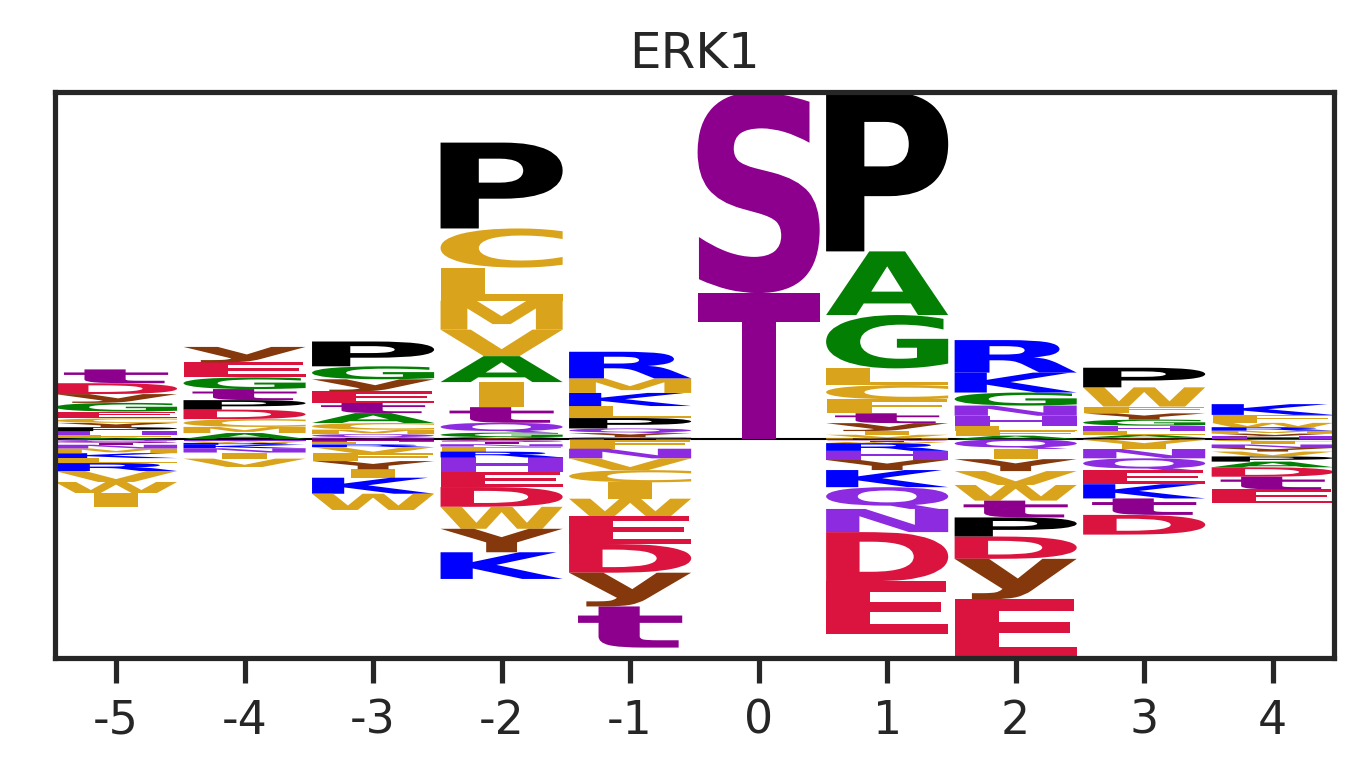

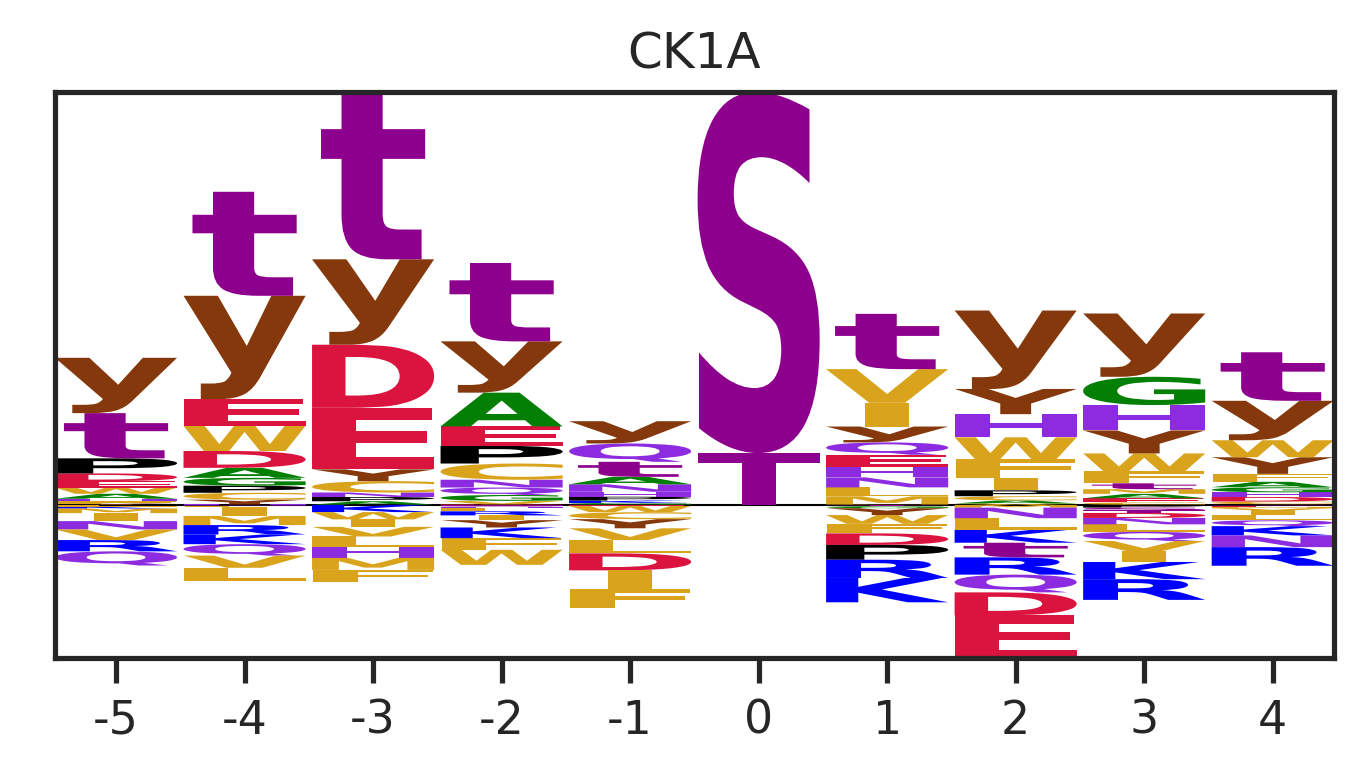

In [ ]:
raw2logo(target.reset_index(),'CK1A')

In [ ]:
pred2.loc['ZAP70'].sort_values(ascending=False)[:10]

-3R    3.477043
1y     2.663688
-2R    2.483023
2R     2.413489
3E     2.211422
2K     2.122138
-1R    1.970297
4K     1.952204
3K     1.938187
-1K    1.911902
Name: ZAP70, dtype: float64

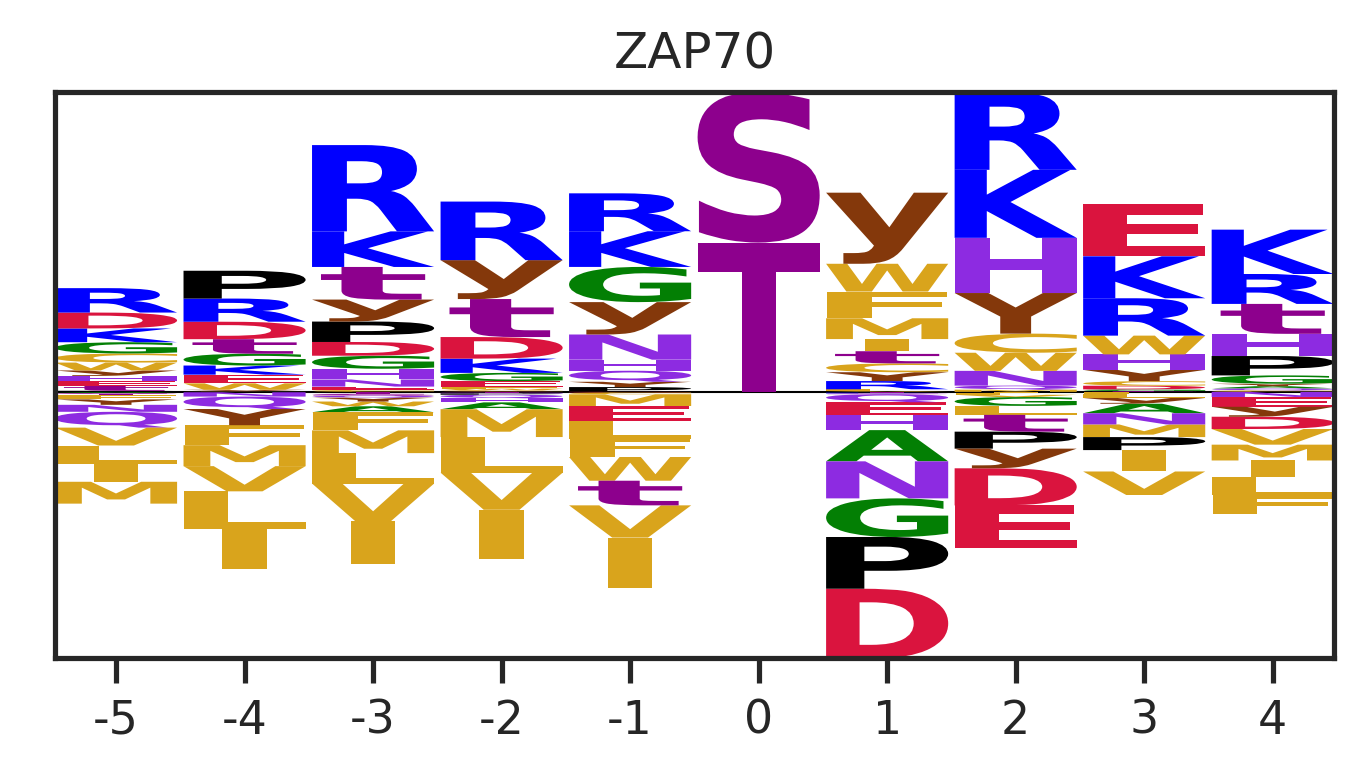

In [ ]:
raw2logo(pred2.reset_index(),'ZAP70')

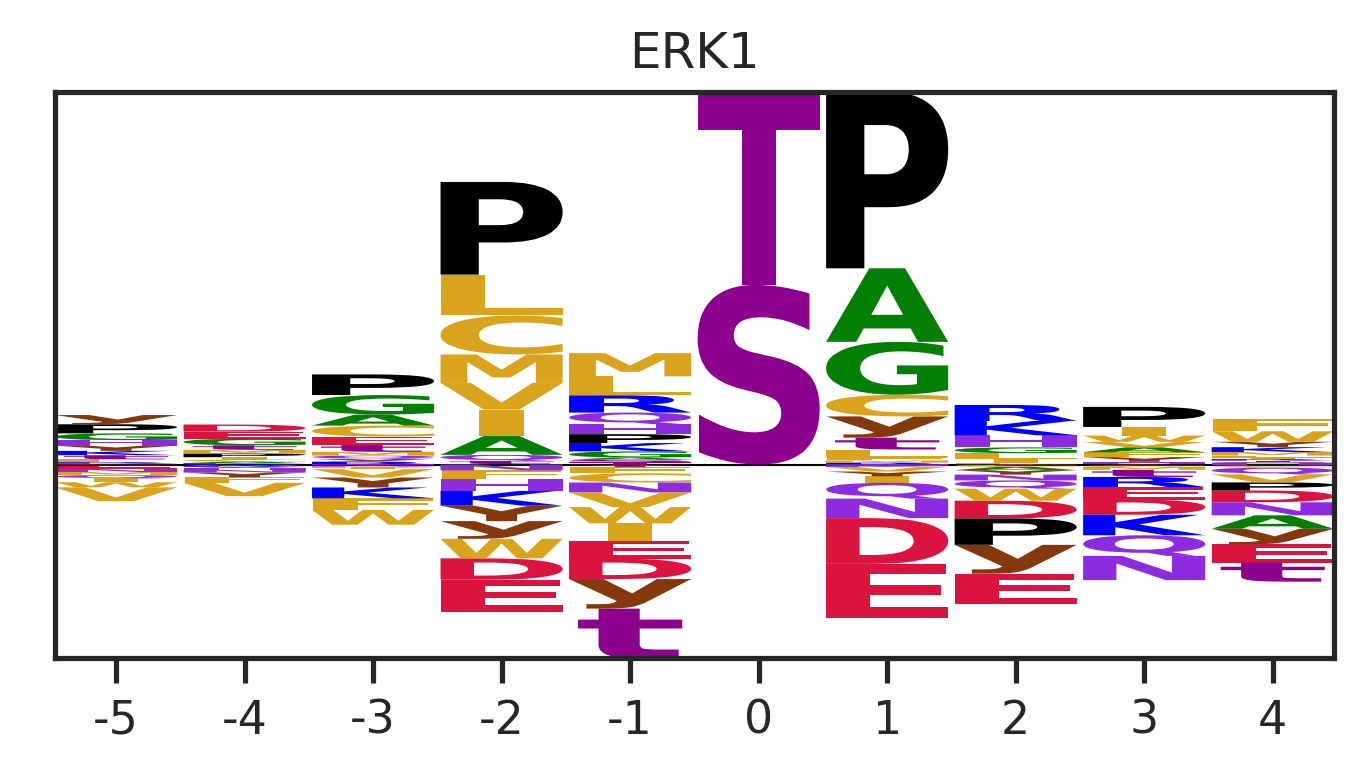

In [ ]:
raw2logo(pred2.reset_index(),'ERK1')

In [ ]:
plot_assay(raw2, "CDK7")

,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,0.913697,0.918897,0.747244,0.645401,1.142710,1.102408,1.290265,0.894453,1.878886,1.200215,1.143445,0.955383,1.037659,0.996386,1.359748,0.882448,1.035244,0.933902,1.023715,1.329202,0.895476,0.818958,0.991820,1.352649,1.071442,0.959768,1.161525,0.873108,1.476051,0.820276,1.032782,0.990274,1.477073,1.362824,0.636545,1.606471,1.159429,1.123995,2.108678,0.775943,0.944271,1.044189,1.039752,1.001080,1.147072,1.207292,0.845172,0.883013,0.907856,0.821604,1.017244,1.082798,1.169190,0.993333,1.204671,0.944626,0.947628,1.048903,1.295328,1.077678,1.557982,1.021175,0.986349,0.988980,1.363336,0.941777,1.141362,1.256387,1.050143,1.298816,1.051504,1.066030,1.164043,1.039611,1.220932,1.064604,1.128606,1.013280,0.873335,1.113864,1.240596,1.200467,1.391432,1.106048,1.078716,1.126851,1.207995,1.090140,1.030965,1.288133,1.020517,0.945191,1.419296,0.866131,1.103593,1.550179,1.016124,1.244867,1.186935,0.963700,1.097291,1.088242,1.416653,1.210637,1.840861,1.300761,1.116426,1.689651,1.057473,1.297909,0.767065,1.028409,0.904575,0.677564,0.792895,7.271335,0.768782,0.882497,0.687959,0.767853,0.866357,0.762097,0.818200,0.674513,0.791222,0.848628,1.557598,0.773397,0.846729,0.806195,0.984070,0.769699,1.195404,1.347749,1.030648,0.931813,0.942306,1.129229,2.099029,0.853412,1.075612,0.824195,0.952394,1.369541,0.862488,1.164347,1.304869,1.223848,3.025127,0.998912,1.102422,1.154491,1.369907,0.997744,1.006924,1.410546,1.031968,0.974255,0.996711,1.449843,1.390751,0.893451,1.270908,1.013653,0.935971,1.287532,1.055410,1.119853,1.407556,1.073029,3.222095,1.046084,1.176244,1.206548,1.113100,1.012649,1.050351,1.260094,0.999014,1.002401,1.112034,1.142746,1.138872,0.993211,1.370541,1.085130,1.035920,1.092811,1.106641,1.191371,1.479948,1.090898,2.292133,0.969805,1.667448,1.271786,1.120160,0.871545
ABL1,1.537519,1.158197,1.137087,0.957517,0.712672,1.524427,1.191915,0.533487,2.471129,0.938210,1.388563,1.741409,1.542672,1.753279,2.102510,2.003197,1.325647,0.792530,0.847271,1.120614,0.534919,1.188718,1.845466,2.830933,1.123177,0.881579,0.950924,1.136333,1.048176,0.828046,1.027032,0.723737,1.101942,3.165357,0.633070,1.512315,1.094348,5.693855,2.544136,1.217934,1.221582,0.986354,0.747629,0.797967,0.926170,1.099390,0.591731,0.620560,0.820084,0.851761,1.231423,0.591899,2.621554,0.974533,2.018714,0.970680,0.957803,1.000896,5.483524,1.373327,0.939968,0.537532,0.881305,0.646068,0.739726,0.675943,1.456666,1.571918,0.990184,1.146077,1.035876,1.241205,1.267826,1.065150,1.534573,1.216099,1.729115,1.145178,1.336582,1.262182,1.733649,1.597399,1.185605,1.166874,1.745067,1.065408,0.989199,0.744937,1.063102,1.441878,1.064924,0.750523,1.076812,0.935567,0.977190,1.662083,1.314666,1.580818,1.130532,1.000135,0.848479,0.828328,1.446683,1.044853,0.853852,1.258433,1.020204,0.912373,0.682140,0.728447,0.962550,1.733715,0.564751,0.685038,2.458087,1.069156,1.157744,1.123351,1.287000,1.058084,1.805282,1.235743,0.723176,1.805767,1.547718,2.213144,1.518487,1.196176,1.337146,1.930280,1.157371,1.060264,0.888594,1.455471,0.545993,0.444178,0.926362,1.059073,1.642682,1.296766,1.392575,1.137240,1.259396,1.323154,0.

In [ ]:
# splits = get_splits(info, stratified = 'hdbscan')

# model  = LinearRegression()

# target, pred = train_ml(df,feat_col, target_col, splits,model, 'model.joblib')

# cor = score_each(target,pred,info)

# predict
# X_train, y_train, X_test, y_test = split_data(df,feat_col,target_col,splits)

# def train_df(df, model):
    
#     feat_col = df.columns.tolist()[199:]
#     target_col = df.columns.tolist()[1:199]

#     # prepare the dataframe for split
#     kinase = Data.get_kinase_info_full()

#     info = df[['kinase']].merge(kinase,'left')
#     print((info.kinase == df.kinase).value_counts())
    
    
#     skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
#     for fold, (train_idx, test_idx) in enumerate(skf.split(info.index, info.category)):
#         print(f'# kinase in test set: {info.loc[test_idx].kinase.unique().shape[0]}')
#         print(f'# kinase in train set: {info.loc[train_idx].kinase.unique().shape[0]}')
#         print(f'test set: {info.loc[test_idx].kinase.unique()}')
#         break
    
#     X_train = df.loc[train_idx][feat_col]
#     X_test = df.loc[test_idx][feat_col]
#     y_train = df.loc[train_idx][target_col]
#     y_test = df.loc[test_idx][target_col]
    
#     pred = train_ML(model,X_train, X_test, y_train, y_test)

In [ ]:
# df1 = pd.read_parquet('train/scaled_esm.parquet')

# df2 = pd.read_parquet('train/scaled_esmPCA.parquet')

# df3 = pd.read_parquet('train/scaled_t5.parquet')

# df4 = pd.read_parquet('train/scaled_t5PCA.parquet')

# dfs = {'esm':df1, 'esmPCA':df2, 't5':df3, 't5PCA':df4}